# Introduction
The telecom operator Interconnect would like to be able to forecast their churn of clients. If it's discovered that a user is planning to leave, they will be offered promotional codes and special plan options. In this project I will be training a machine learning model to predict the churn of their clients.

##### Data Description

The data consists of files obtained from different sources:

- `contract.csv` — contract information.
- `personal.csv` — the client's personal data.
- `internet.csv` — information about internet services.
- `phone.csv` — information about telephone services.

In each file, the column `customerID` contains a unique code assigned to each client.

The contract information is valid as of February 1, 2020.



### Initialization

In [1]:
# general
import pandas as pd
import numpy as np
import math
from scipy import stats as st
import joblib as jbl
from tqdm.auto import tqdm
import re 

# for graphing
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns #boxplot
sns.set_style('darkgrid')
from plotly import express as px, graph_objects as go

# for machine learning
from sklearn import model_selection as sel, metrics as met, preprocessing as pro
from sklearn import dummy as dum, multioutput as mul
from sklearn import svm, tree, ensemble as ens, linear_model as lin, neighbors as nei
import lightgbm as lgb


##### Loading Datasets

In [2]:
try:
    contract = pd.read_csv('Downloads/final_provider/final_provider/contract.csv')
    personal = pd.read_csv('Downloads/final_provider/final_provider/personal.csv')
    internet = pd.read_csv('Downloads/final_provider/final_provider/internet.csv')
    phone = pd.read_csv('Downloads/final_provider/final_provider/phone.csv')
except:
    contract = pd.read_csv('/datasets/final_provider/final_provider/contract.csv')
    personal = pd.read_csv('/datasets/final_provider/final_provider/personal.csv')
    internet = pd.read_csv('/datasets/final_provider/final_provider/internet.csv')
    phone = pd.read_csv('/datasets/final_provider/final_provider/phone.csv')



##### A Look Into the Data

In [3]:
contract.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   BeginDate         7043 non-null   object 
 2   EndDate           7043 non-null   object 
 3   Type              7043 non-null   object 
 4   PaperlessBilling  7043 non-null   object 
 5   PaymentMethod     7043 non-null   object 
 6   MonthlyCharges    7043 non-null   float64
 7   TotalCharges      7043 non-null   object 
dtypes: float64(1), object(7)
memory usage: 440.3+ KB


There are no null values. We have one numeric column and all others are of object data type.

In [4]:
personal.info() # no nulls, one numeric and all else object 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     7043 non-null   object
 1   gender         7043 non-null   object
 2   SeniorCitizen  7043 non-null   int64 
 3   Partner        7043 non-null   object
 4   Dependents     7043 non-null   object
dtypes: int64(1), object(4)
memory usage: 275.2+ KB


Again, no null values, one numeric column and all other columns are of object data type.

In [5]:
internet.info() # all object. no nulls, but fewer rows, some clients don't have internet

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5517 entries, 0 to 5516
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   customerID        5517 non-null   object
 1   InternetService   5517 non-null   object
 2   OnlineSecurity    5517 non-null   object
 3   OnlineBackup      5517 non-null   object
 4   DeviceProtection  5517 non-null   object
 5   TechSupport       5517 non-null   object
 6   StreamingTV       5517 non-null   object
 7   StreamingMovies   5517 non-null   object
dtypes: object(8)
memory usage: 344.9+ KB


No numeric columns in this table, and no null values. There are fewer customers in the internet table than in the personal and contract tables, meaning some customers are not connected to internet services - 1526 to be exact.

In [6]:
phone.info() # all object. also fewer than amount of customers

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6361 entries, 0 to 6360
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     6361 non-null   object
 1   MultipleLines  6361 non-null   object
dtypes: object(2)
memory usage: 99.5+ KB


No numeric columns in this table either, and no null values. There are fewer customers in the phone table than in the personal and contract tables - there are 682 customers not connected to phone services.

### Data Preprocessing
##### The Contract Table
<a name = 'preprocessing' id = 'preprocessing'></a>

In [7]:
contract.head() # a lot of issues with the types

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,29.85
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,1889.5
2,3668-QPYBK,2019-10-01,2019-12-01 00:00:00,Month-to-month,Yes,Mailed check,53.85,108.15
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1840.75
4,9237-HQITU,2019-09-01,2019-11-01 00:00:00,Month-to-month,Yes,Electronic check,70.70,151.65


The coulmn BeginDate is a string column representing dates. The EndDate column is a string column containing dates and 'No'. The column PaperlessBilling contains values of 'Yes' and 'No', but I don't know for sure if those are the only values in it.

In [8]:
contract.describe(include = 'all') # total charges has a space as most frequent value

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
count,7043,7043,7043,7043,7043,7043,7043.000000,7043
unique,7043,77,5,3,2,4,NaN,6531
top,7590-VHVEG,2014-02-01,No,Month-to-month,Yes,Electronic check,NaN,
freq,1,366,5174,3875,4171,2365,NaN,11
mean,NaN,NaN,NaN,NaN,NaN,NaN,64.761692,NaN
std,NaN,NaN,NaN,NaN,NaN,NaN,30.090047,NaN
min,NaN,NaN,NaN,NaN,NaN,NaN,18.250000,NaN
25%,NaN,NaN,NaN,NaN,NaN,NaN,35.500000,NaN
50%,NaN,NaN,NaN,NaN,NaN,NaN,70.350000,NaN
75%,NaN,NaN,NaN,NaN,NaN,NaN,89.850000,NaN


There are 2 unique values in PaperlessBilling, meaning the values in it are only 'Yes' and 'No'. I intend to encode 'Yes' as 1 and 'No' as 0 later on. 

The column EndDate contains 7,043 values, out of which 5,174 are 'No' - more than half of rows don't have a leaving date, meaning those are the customers who hadn't left. 

The TotalCharges column seems to have 11 values of ' '. 

In [9]:
contract.TotalCharges.value_counts()
# 11 ' '
# filling in for 0?

          11
20.2      11
19.75      9
20.05      8
19.9       8
          ..
6849.4     1
692.35     1
130.15     1
3211.9     1
6844.5     1
Name: TotalCharges, Length: 6531, dtype: int64

Since the values in TotalCharges are sums, the spaces might be filling for zeros.

In [10]:
contract.TotalCharges = pd.to_numeric(contract.TotalCharges.replace(to_replace = ' ', value = 0))
contract.TotalCharges.value_counts()
# the only zeros are the ones created by replacing the spaces
# which strengthens the claim that they might have been filling in for 0

0.00       11
20.20      11
19.75       9
20.05       8
19.90       8
           ..
6849.40     1
692.35      1
130.15      1
3211.90     1
6844.50     1
Name: TotalCharges, Length: 6531, dtype: int64

Those 11 values are the only zeros in the column, which makes sense if they were filling in for zeros, and if not, they are of negligible quantity in comparison to the total quantity of observations in our data.

###### Extracting Target Before Further Cleaning

In [11]:
y = contract.set_index('customerID').EndDate
y = y.map(lambda x: 0 if x=='No' else 1).rename('churn') # y is the churn
y

customerID
7590-VHVEG    0
5575-GNVDE    0
3668-QPYBK    1
7795-CFOCW    0
9237-HQITU    1
             ..
6840-RESVB    0
2234-XADUH    0
4801-JZAZL    0
8361-LTMKD    1
3186-AJIEK    0
Name: churn, Length: 7043, dtype: int64

I extracted a binary-classification target from the EndDate column, classifying churned customers as 1 and staying customers as 0.

In [12]:
y.value_counts(normalize = True) # there is class imbalance, more staying customers than leaving customers
# but I don't think it is so drastic that it requires upsampling

0    0.73463
1    0.26537
Name: churn, dtype: float64

There is a class imbalance: 26% of the observations are of the positive class. In my opinion this imbalance is not so drastic that it requires upsampling.

In [13]:
# changing begindate to datetime
form = '%Y-%m-%d'
contract.BeginDate = pd.to_datetime(contract.BeginDate, format = form)

# also changing enddate to datetime for analysis
pres = '2020-02-02' # one day after the data collection was done -
# an invalid date so we can differentiate
contract.EndDate = pd.to_datetime(contract.EndDate.replace({'No':pres}), 
                                  format = form)

contract.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   customerID        7043 non-null   object        
 1   BeginDate         7043 non-null   datetime64[ns]
 2   EndDate           7043 non-null   datetime64[ns]
 3   Type              7043 non-null   object        
 4   PaperlessBilling  7043 non-null   object        
 5   PaymentMethod     7043 non-null   object        
 6   MonthlyCharges    7043 non-null   float64       
 7   TotalCharges      7043 non-null   float64       
dtypes: datetime64[ns](2), float64(2), object(4)
memory usage: 440.3+ KB


Now our datetime columns are in the correct format and fit for analysis.

In [14]:
contract.Type.value_counts()
# would be easier to teach machine if as numeric
# this is essentially the number of months a client is willing to obligate to in advance

Month-to-month    3875
Two year          1695
One year          1473
Name: Type, dtype: int64

Contract type is the frequency in which a client has to renew it - or how long they are willing to sign up for with their company. The contracts available are monthly, yearly, or two years long.

In [15]:
contract.PaperlessBilling.value_counts() # this is a binary field

Yes    4171
No     2872
Name: PaperlessBilling, dtype: int64

This field would work perfectly well as binary data.

In [16]:
# converting contract type to length of contract in months
contract.Type = pd.to_numeric(contract.Type.replace({'Month-to-month':1,
                                                    'Two year':24,
                                                    'One year':12}))
yesno = {'Yes':1, 'No':0} # saving a binary dictionary bc I'm going to do that a lot
contract.PaperlessBilling = pd.to_numeric(contract.PaperlessBilling.replace(yesno))
contract.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   customerID        7043 non-null   object        
 1   BeginDate         7043 non-null   datetime64[ns]
 2   EndDate           7043 non-null   datetime64[ns]
 3   Type              7043 non-null   int64         
 4   PaperlessBilling  7043 non-null   int64         
 5   PaymentMethod     7043 non-null   object        
 6   MonthlyCharges    7043 non-null   float64       
 7   TotalCharges      7043 non-null   float64       
dtypes: datetime64[ns](2), float64(2), int64(2), object(2)
memory usage: 440.3+ KB


The change is successful.

In [17]:
contract.PaymentMethod.value_counts() # these options don't quite compare to one another
# not too many, ohe will fit

Electronic check             2365
Mailed check                 1612
Bank transfer (automatic)    1544
Credit card (automatic)      1522
Name: PaymentMethod, dtype: int64

The PaymentMethod column contains four unique values. Encoding them using label encoding wouldn't convey their meaning - the value encoded 2 wouldn't be smaller than the value encoded 3, but the machine learning algorithms would learn it as if it is. For this reason I will use One-Hot-Encoding for this column later.

##### The Personal table

In [18]:
personal.info()
# like contract it has all of the clients
personal.head()
# here too, binary columns as object datatype

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     7043 non-null   object
 1   gender         7043 non-null   object
 2   SeniorCitizen  7043 non-null   int64 
 3   Partner        7043 non-null   object
 4   Dependents     7043 non-null   object
dtypes: int64(1), object(4)
memory usage: 275.2+ KB


,customerID,gender,SeniorCitizen,Partner,Dependents
0,7590-VHVEG,Female,0,Yes,No
1,5575-GNVDE,Male,0,No,No
2,3668-QPYBK,Male,0,No,No
3,7795-CFOCW,Male,0,No,No
4,9237-HQITU,Female,0,No,No


The columns Partner and Dependents should be binary, the same way SeniorCitizen already is.

In [19]:
personal.describe(include = 'all') # gender has just too options too

,customerID,gender,SeniorCitizen,Partner,Dependents
count,7043,7043,7043.000000,7043,7043
unique,7043,2,NaN,2,2
top,7590-VHVEG,Male,NaN,No,No
freq,1,3555,NaN,3641,4933
mean,NaN,NaN,0.162147,NaN,NaN
std,NaN,NaN,0.368612,NaN,NaN
min,NaN,NaN,0.000000,NaN,NaN
25%,NaN,NaN,0.000000,NaN,NaN
50%,NaN,NaN,0.000000,NaN,NaN
75%,NaN,NaN,0.000000,NaN,NaN


The gender column could also be encoded as zeros and ones, since the column contains only two values.

In [20]:
personal.SeniorCitizen.value_counts() # found no unexpected values
# most aren't senior citizens

0    5901
1    1142
Name: SeniorCitizen, dtype: int64

There are no unexpected values in the SeniorCitizen - it does not require fixing.

In [21]:
print(personal.Partner.value_counts())
print(personal.gender.value_counts())
personal.Dependents.value_counts() # no unexpected values anywhere
# these columns could all be 0,1

No     3641
Yes    3402
Name: Partner, dtype: int64
Male      3555
Female    3488
Name: gender, dtype: int64


No     4933
Yes    2110
Name: Dependents, dtype: int64

There are only two values in each of the non-numeric columns in the table. I will convert 'Yes':'No' values to 1:0 now, and encode gender as numbers later.

In [22]:
personal.Partner = pd.to_numeric(personal.Partner.replace(yesno))
personal.Dependents = pd.to_numeric(personal.Dependents.replace(yesno))

personal.info() # transformation successful
# will encode gender when collecting the features

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     7043 non-null   object
 1   gender         7043 non-null   object
 2   SeniorCitizen  7043 non-null   int64 
 3   Partner        7043 non-null   int64 
 4   Dependents     7043 non-null   int64 
dtypes: int64(3), object(2)
memory usage: 275.2+ KB


##### The Internet table

In [23]:
internet.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5517 entries, 0 to 5516
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   customerID        5517 non-null   object
 1   InternetService   5517 non-null   object
 2   OnlineSecurity    5517 non-null   object
 3   OnlineBackup      5517 non-null   object
 4   DeviceProtection  5517 non-null   object
 5   TechSupport       5517 non-null   object
 6   StreamingTV       5517 non-null   object
 7   StreamingMovies   5517 non-null   object
dtypes: object(8)
memory usage: 344.9+ KB


Fewer entries in the internet table compared to the personal and contract tables, meaning when joining the features later on I should expect plenty of null values.

In [24]:
internet.head() # most columns should be 0s and 1s

,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
0,7590-VHVEG,DSL,No,Yes,No,No,No,No
1,5575-GNVDE,DSL,Yes,No,Yes,No,No,No
2,3668-QPYBK,DSL,Yes,Yes,No,No,No,No
3,7795-CFOCW,DSL,Yes,No,Yes,Yes,No,No
4,9237-HQITU,Fiber optic,No,No,No,No,No,No


The amount of values in InternetService is unclear, but unless there are values filling in for null in any of the other columns indicating internet services, they could all be encoded as binary.

In [25]:
internet.describe(include = 'all')

,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
count,5517,5517,5517,5517,5517,5517,5517,5517
unique,5517,2,2,2,2,2,2,2
top,7590-VHVEG,Fiber optic,No,No,No,No,No,No
freq,1,3096,3498,3088,3095,3473,2810,2785


Other than customerID, all columns only have two values. I will encode columns of 'Yes':'No' values as 1:0, but not the InternetService column.

In [26]:
internet.OnlineBackup = pd.to_numeric(internet.OnlineBackup.replace(yesno))
internet.DeviceProtection = pd.to_numeric(internet.DeviceProtection.replace(yesno))
internet.TechSupport = pd.to_numeric(internet.TechSupport.replace(yesno))
internet.OnlineSecurity = pd.to_numeric(internet.OnlineSecurity.replace(yesno))
internet.StreamingTV = pd.to_numeric(internet.StreamingTV.replace(yesno))
internet.StreamingMovies = pd.to_numeric(internet.StreamingMovies.replace(yesno))
internet.info() # successful transformation

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5517 entries, 0 to 5516
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   customerID        5517 non-null   object
 1   InternetService   5517 non-null   object
 2   OnlineSecurity    5517 non-null   int64 
 3   OnlineBackup      5517 non-null   int64 
 4   DeviceProtection  5517 non-null   int64 
 5   TechSupport       5517 non-null   int64 
 6   StreamingTV       5517 non-null   int64 
 7   StreamingMovies   5517 non-null   int64 
dtypes: int64(6), object(2)
memory usage: 344.9+ KB


The change was successfull.

In [27]:
internet.InternetService.value_counts()
# either digital subscriber line or fiber optic cable

Fiber optic    3096
DSL            2421
Name: InternetService, dtype: int64

I will convert this column to numeric data at a later stage.

##### The Phone table

In [28]:
phone.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6361 entries, 0 to 6360
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     6361 non-null   object
 1   MultipleLines  6361 non-null   object
dtypes: object(2)
memory usage: 99.5+ KB


This table only contains one column of data and the column of customer identification.

In [29]:
phone.describe()

,customerID,MultipleLines
count,6361,6361
unique,6361,2
top,5575-GNVDE,No
freq,1,3390


This column, too, could be converted to binary data.

In [30]:
phone.MultipleLines = pd.to_numeric(phone.MultipleLines.replace(yesno))
phone.describe(include = 'all') # successful transformation

,customerID,MultipleLines
count,6361,6361.000000
unique,6361,NaN
top,5575-GNVDE,NaN
freq,1,NaN
mean,NaN,0.467065
std,NaN,0.498953
min,NaN,0.000000
25%,NaN,0.000000
50%,NaN,0.000000
75%,NaN,1.000000


The change was successful.

##### Combining the Features
- I will be joining the different tables by setting the customerID columns in a copy of each table as index and joining on them. Before that, I have to make sure there are no duplicated customer IDs.
- I will also encode the remaining categorical values:
    - For the 'paymentmethod' column in the 'contract' table I will use OHE, dropping one of the columns so that zeros in all three remaining columns signify the fourth value.
    - For the 'gender' column in the 'personal' table I will use label encoding.
    - For the 'internetservice' column in the 'internet' table I will use OHE, not dropping one of the columns, so that later filling for nulls would make more sense.

In [31]:
print(contract.customerID.duplicated().sum(),
     personal.customerID.duplicated().sum(),
     internet.customerID.duplicated().sum(),
     phone.customerID.duplicated().sum()) 

0 0 0 0


No duplicates - the customerID column would work as index.

In [32]:
contract_ = contract.set_index('customerID')
contract_ = pd.get_dummies(contract_, drop_first = True) #one hot encoding the paymentmethod column
# renaming for convenience
contract_.columns = contract_.columns.str.lower()
contract_ = contract_.rename(columns = {'type':'obligation', 
                                       'paymentmethod_credit card (automatic)':'payment_credit',
                                       'paymentmethod_electronic check':'payment_echeck',
                                       'paymentmethod_mailed check':'payment_check'})
contract_.info() # changes were successful

<class 'pandas.core.frame.DataFrame'>
Index: 7043 entries, 7590-VHVEG to 3186-AJIEK
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   begindate         7043 non-null   datetime64[ns]
 1   enddate           7043 non-null   datetime64[ns]
 2   obligation        7043 non-null   int64         
 3   paperlessbilling  7043 non-null   int64         
 4   monthlycharges    7043 non-null   float64       
 5   totalcharges      7043 non-null   float64       
 6   payment_credit    7043 non-null   uint8         
 7   payment_echeck    7043 non-null   uint8         
 8   payment_check     7043 non-null   uint8         
dtypes: datetime64[ns](2), float64(2), int64(2), uint8(3)
memory usage: 405.8+ KB


PaymentMethod encoded with OHE successfully, columns renamed successfully.

In [33]:
personal_ = personal.set_index('customerID')
personal_ = pd.get_dummies(personal_, drop_first = True) #label encoding the gender column
personal_.columns = personal_.columns.str.lower()
personal_ = personal_.rename(columns = {'gender_male':'male'})
personal_.info() # changes were successful

<class 'pandas.core.frame.DataFrame'>
Index: 7043 entries, 7590-VHVEG to 3186-AJIEK
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype
---  ------         --------------  -----
 0   seniorcitizen  7043 non-null   int64
 1   partner        7043 non-null   int64
 2   dependents     7043 non-null   int64
 3   male           7043 non-null   uint8
dtypes: int64(3), uint8(1)
memory usage: 227.0+ KB


Gender encoded successfully, column renamed to match the data.

In [34]:
phone_ = phone.set_index('customerID')
phone_.columns = phone_.columns.str.lower()
phone_.info() # changes were successful

<class 'pandas.core.frame.DataFrame'>
Index: 6361 entries, 5575-GNVDE to 3186-AJIEK
Data columns (total 1 columns):
 #   Column         Non-Null Count  Dtype
---  ------         --------------  -----
 0   multiplelines  6361 non-null   int64
dtypes: int64(1)
memory usage: 99.4+ KB


Renaming successful.

In [35]:
internet_ = internet.set_index('customerID')
internet_ = pd.get_dummies(internet_, drop_first = False) #one hot encoding the internetservice column
internet_.columns = internet_.columns.str.lower()
# renaming for convenience
internet_ = internet_.rename(columns = {'internetservice_fiber optic':'fiberoptic',
                                       'internetservice_dsl':'dsl'})
internet_.info() # changes were successful

<class 'pandas.core.frame.DataFrame'>
Index: 5517 entries, 7590-VHVEG to 3186-AJIEK
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype
---  ------            --------------  -----
 0   onlinesecurity    5517 non-null   int64
 1   onlinebackup      5517 non-null   int64
 2   deviceprotection  5517 non-null   int64
 3   techsupport       5517 non-null   int64
 4   streamingtv       5517 non-null   int64
 5   streamingmovies   5517 non-null   int64
 6   dsl               5517 non-null   uint8
 7   fiberoptic        5517 non-null   uint8
dtypes: int64(6), uint8(2)
memory usage: 312.5+ KB


Successful OHE and renaming.

In [36]:
# outer joining all
all_data = contract_.join(personal_.join(internet_.join(phone_, 
                                                        how = 'outer'),
                                        how = 'outer'),
                         how = 'outer')
len(all_data), len(contract) # should be identical

(7043, 7043)

The outer join of all tables was successful.

In [37]:
all_data.info() # the join appears to be successful

<class 'pandas.core.frame.DataFrame'>
Index: 7043 entries, 0002-ORFBO to 9995-HOTOH
Data columns (total 22 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   begindate         7043 non-null   datetime64[ns]
 1   enddate           7043 non-null   datetime64[ns]
 2   obligation        7043 non-null   int64         
 3   paperlessbilling  7043 non-null   int64         
 4   monthlycharges    7043 non-null   float64       
 5   totalcharges      7043 non-null   float64       
 6   payment_credit    7043 non-null   uint8         
 7   payment_echeck    7043 non-null   uint8         
 8   payment_check     7043 non-null   uint8         
 9   seniorcitizen     7043 non-null   int64         
 10  partner           7043 non-null   int64         
 11  dependents        7043 non-null   int64         
 12  male              7043 non-null   uint8         
 13  onlinesecurity    5517 non-null   float64       
 14  onlinebackup  

We now have 21 columns of data, of which 9 columns contain null values.

Filling nulls with -1 works well for only some of the columns:
- The only column joined from the phone data is multiplelines, which has 1 for users with multiple phone lines in their contract, 0 for one phone line, and will have -1 for zero phone lines. A descending number labeling descending quantity.
- The columns signifying internet products have 1 for customers subscribed internet and subscribed to them, 0 for customers subscribed to internet and not to the product, and will have -1 for customers subscribed to neither option.
- I'll fill columns fiberoptic and dsl with 0 to show that there is neither internet service option. It's possible to encode them as one numeric feature ranging from -1 (not connected to internet) to 1, but choosing which of the connection options will be 1 and which will be 0 is arbitrary. OHE fits this column better.

In [38]:
all_data[['dsl', 'fiberoptic']] = all_data[['dsl', 'fiberoptic']].fillna(0)
all_data = all_data.fillna(-1)
all_data.info()
# change successful

<class 'pandas.core.frame.DataFrame'>
Index: 7043 entries, 0002-ORFBO to 9995-HOTOH
Data columns (total 22 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   begindate         7043 non-null   datetime64[ns]
 1   enddate           7043 non-null   datetime64[ns]
 2   obligation        7043 non-null   int64         
 3   paperlessbilling  7043 non-null   int64         
 4   monthlycharges    7043 non-null   float64       
 5   totalcharges      7043 non-null   float64       
 6   payment_credit    7043 non-null   uint8         
 7   payment_echeck    7043 non-null   uint8         
 8   payment_check     7043 non-null   uint8         
 9   seniorcitizen     7043 non-null   int64         
 10  partner           7043 non-null   int64         
 11  dependents        7043 non-null   int64         
 12  male              7043 non-null   uint8         
 13  onlinesecurity    7043 non-null   float64       
 14  onlinebackup  

Null values filled successfully.

To explore the connections between the features I intend to use and my target, I will drop the enddate column and replace it with the churn column. I will also convert the begindate column to unix time so that it would be fit for model training.

In [39]:
# joining target and all columns for analysis, dropping previous target
eda = all_data.drop('enddate', axis = 1).join(y)
# converting to unix
eda.begindate = (eda.begindate - pd.Timestamp("1970-01-01")) // pd.Timedelta('1s')

eda.info()
y
# all looks as it should

<class 'pandas.core.frame.DataFrame'>
Index: 7043 entries, 0002-ORFBO to 9995-HOTOH
Data columns (total 22 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   begindate         7043 non-null   int64  
 1   obligation        7043 non-null   int64  
 2   paperlessbilling  7043 non-null   int64  
 3   monthlycharges    7043 non-null   float64
 4   totalcharges      7043 non-null   float64
 5   payment_credit    7043 non-null   uint8  
 6   payment_echeck    7043 non-null   uint8  
 7   payment_check     7043 non-null   uint8  
 8   seniorcitizen     7043 non-null   int64  
 9   partner           7043 non-null   int64  
 10  dependents        7043 non-null   int64  
 11  male              7043 non-null   uint8  
 12  onlinesecurity    7043 non-null   float64
 13  onlinebackup      7043 non-null   float64
 14  deviceprotection  7043 non-null   float64
 15  techsupport       7043 non-null   float64
 16  streamingtv       7043 non-null 

customerID
7590-VHVEG    0
5575-GNVDE    0
3668-QPYBK    1
7795-CFOCW    0
9237-HQITU    1
             ..
6840-RESVB    0
2234-XADUH    0
4801-JZAZL    0
8361-LTMKD    1
3186-AJIEK    0
Name: churn, Length: 7043, dtype: int64

The changes appear successful.

### Exploratory Data Analysis
I intend to explore tables seperately, then explore the combined data.


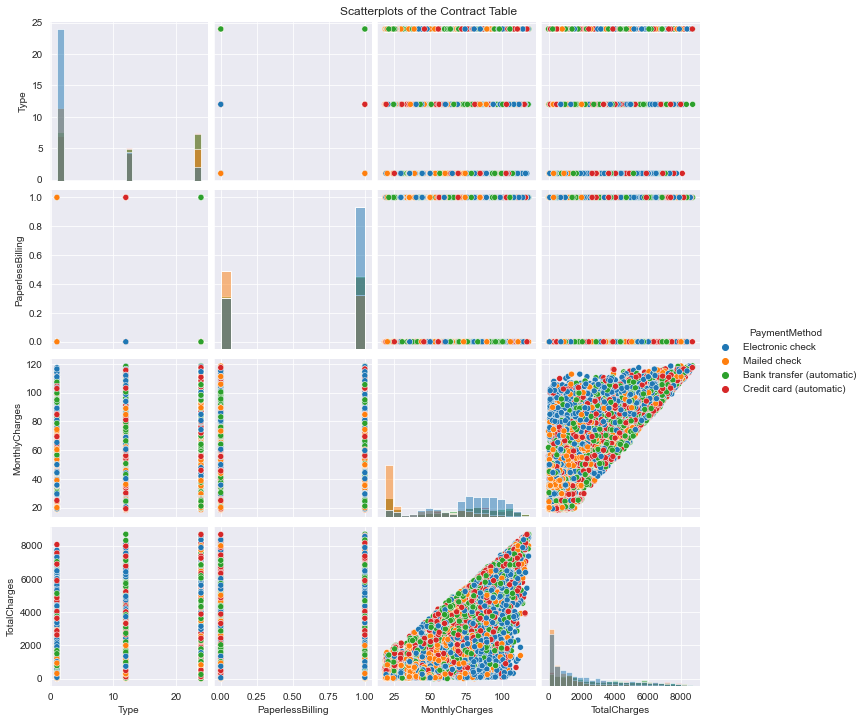

In [40]:
# i want to see the way features are connected
g = sns.pairplot(contract, hue = 'PaymentMethod', diag_kind='hist')
g.figure.suptitle('Scatterplots of the Contract Table', y=1)
plt.show()

We can see that out of month-to-month clients the majority pay with electronic check, and so do the majority of clients who use paperless billing.

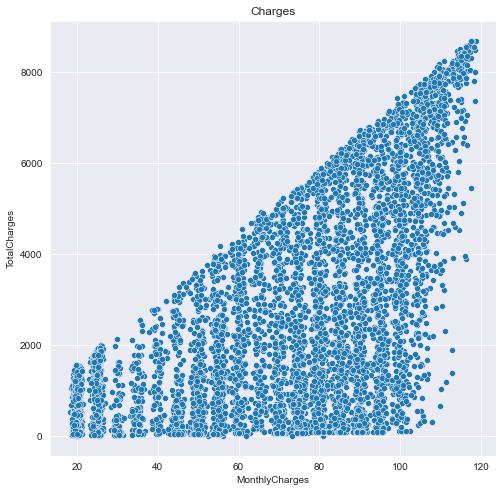

In [41]:
plt.figure(figsize=(8,8))
sns.scatterplot(data = contract, x = 'MonthlyCharges', y = 'TotalCharges'
               ).set(title = 'Charges')
plt.show()

 The total sum a client has been charged ranges over 8,000, with the upper bound seemingly dependant on the client's monthly price. Alongside clients who pay high monthly prices and paid a high total, there are clients with high monthly prices yet a relatively low total charge - they must have stayed for very few months.

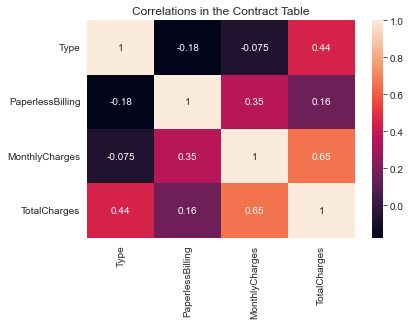

In [42]:
sns.heatmap(contract.corr(), annot=True)
plt.title('Correlations in the Contract Table')
plt.show() 

Reasonably, MonthlyCharges and TotalCharges are strongly correlated, and Type, meaning the length of the contract in months, is positively correlated with the TotalCharges column. PaperlessBilling is more strongly connected to other columns than I expected.

In [43]:
print(contract.BeginDate.min(), contract.BeginDate.max())
# there is a little over 6 years of customers in our data
# including customers that joined the day before collection ended

2013-10-01 00:00:00 2020-02-01 00:00:00


The contracts in our data started as late as the last day of data collection and as early as October 2013.

In [44]:
print(contract.EndDate.min(), contract.EndDate.max())
# we only have clients who left in the year and a half before the end of collection

2019-10-01 00:00:00 2020-02-02 00:00:00


The earliest-leaving clients in the dataset left in October 2019, half a year before the end of data collection.

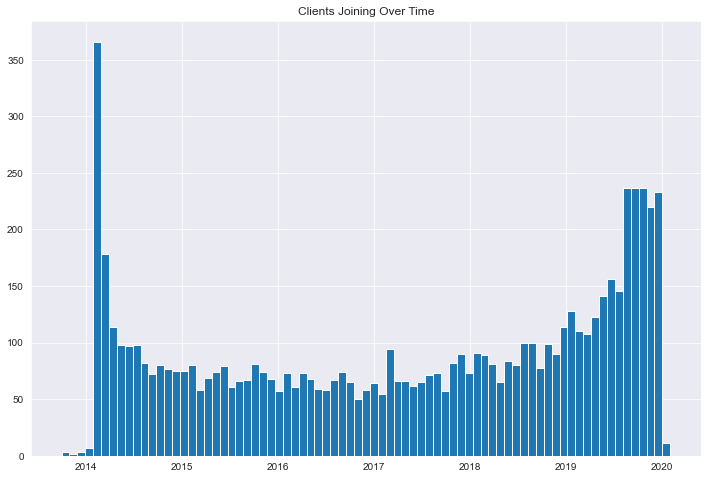

In [45]:
fig = contract.BeginDate.hist(bins = 77, # six years and 5 more months
                              figsize = (12,8))
fig.set_title('Clients Joining Over Time')
plt.show() # a few outliers that joined before 2014, few enough not to be a problem

The clients who joined on 2013 appear to be outliers in our data. There are over 350 clients who joined on Januaryat the start of 2014, as well as a sudden increase in clients between near the end of 2019, according to our records.

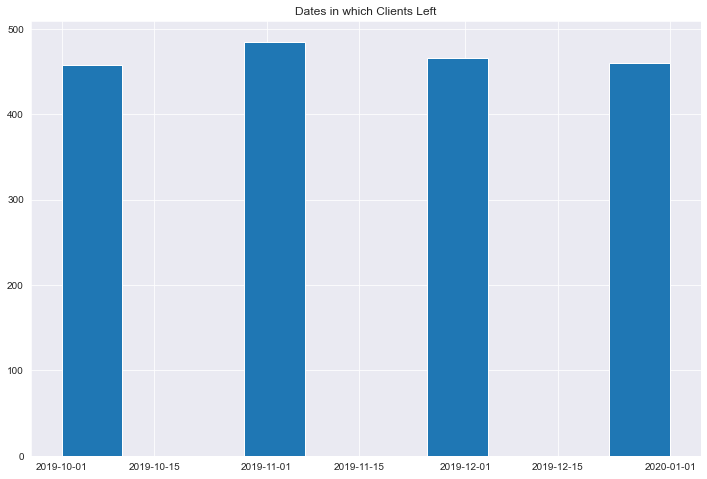

In [46]:
fig = contract[contract['EndDate']<'2020-02-02' #graphing only the actual leaving dates
              ].EndDate.hist(bins = 10,figsize = (12,8))
fig.set_title('Dates in which Clients Left')
plt.show()

There are less than 2,000 records in our dataset of clients who have left, and all of them in the last half-year before the end of data collection. I think older records of churned clients have been deleted, perhaps to save computer memory.

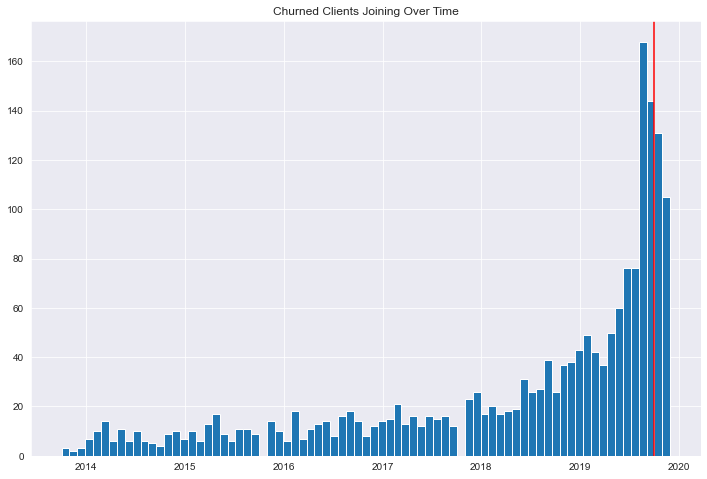

In [47]:
fig = contract[contract['EndDate']<'2020-02-02'].BeginDate.hist(bins = 77,
                              figsize = (12,8))
plt.axvline(x = contract['EndDate'].min(), color = 'red')
fig.set_title('Churned Clients Joining Over Time')
plt.show()

Apparently, a few hundreds of the churned clients in our records have left within half a year of joining. If the records of any client who has left before October 2019 really have been deleted, then we are looking at a half-year long slice of leaving clients, and we can see that new clients have a higher leaving rate at a given point in time compared to older clients.

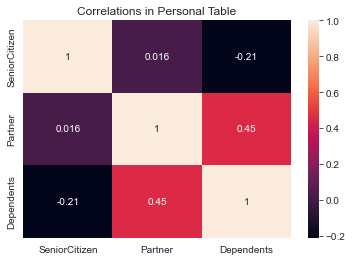

In [48]:
sns.heatmap(personal.corr(), annot=True).set(title = 'Correlations in Personal Table')
plt.show() 
# people with partners are more likely to have young children and seniors are more likely not too

The columns Partner and Dependants are positively correlated, while SeniorCitizen and Dependants are negatively correlated, as would be expected.

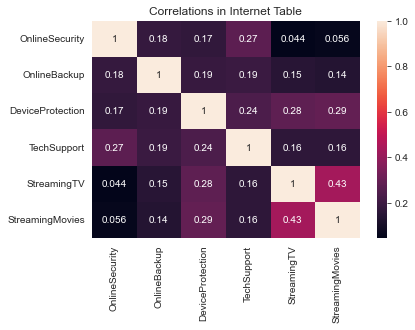

In [49]:
sns.heatmap(internet.corr(), annot=True).set(title = 'Correlations in Internet Table')
plt.show() 
# no negative correlations between subscribing to one product and subscribing to another
# the two streaming services cater to similar populations
# these streaming populations seem to favor device protection over online security

There are no negative correlations between features of this table - subscribing to an internet product apparently increases the likelihood to subscribing to others. This is especially true of consumers of streaming services subscribing to both the television and movie services. Clients subscribed to streaming services seem to favor DeviceProtection over OnlineSecurity, and clients subscribed to TechSupport prefer the other way around.

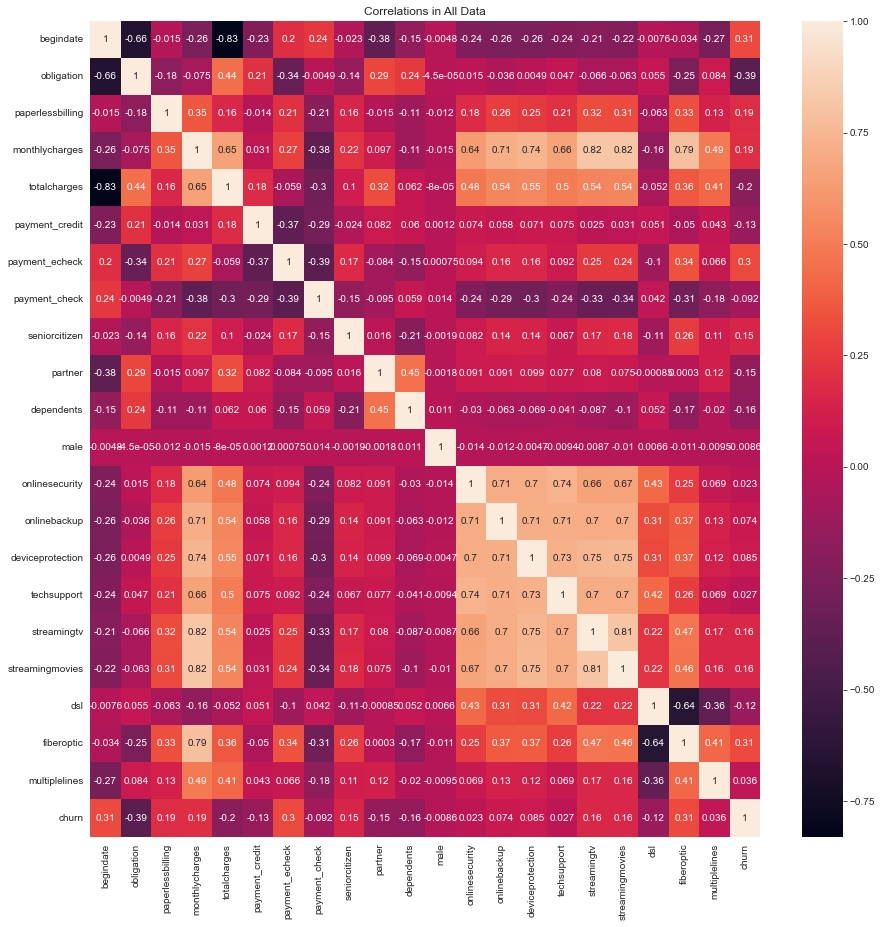

In [50]:
fig, ax = plt.subplots(figsize=(15,15))
sns.heatmap(eda.corr(), annot = True, ax=ax).set(title = 'Correlations in All Data')
plt.show() # too much data to process
# male columns has no influence

A client's gender is not correlated with any other feature. The columns signifying internet products and services are correlated more strongly now that they all share -1 for all customers without an internet connection. The features most connected to client churn are a begining date and fiberoptic internet connection.

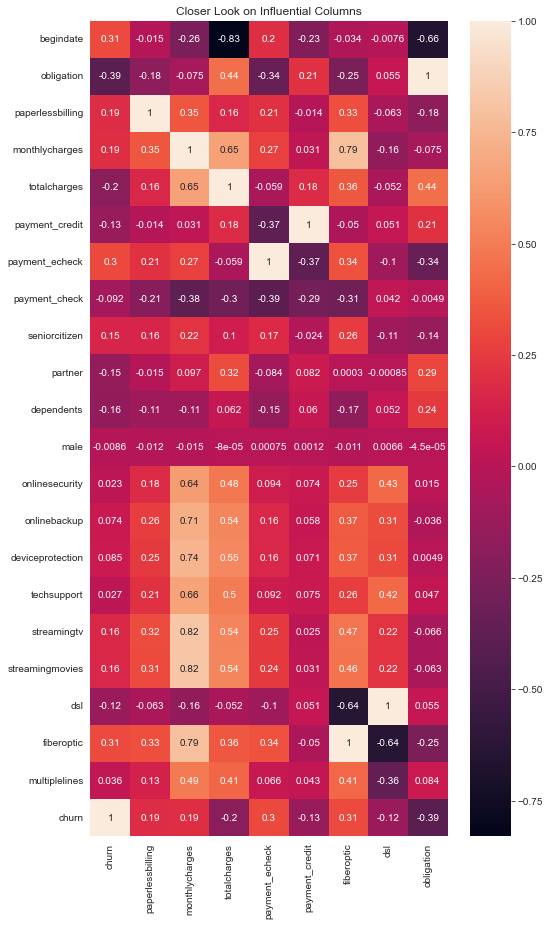

In [51]:
fig, ax = plt.subplots(figsize=(8,15))
sns.heatmap(eda.corr()[['churn', 'paperlessbilling', 'monthlycharges', 'totalcharges',
                        'payment_echeck', 'payment_credit',
                        'fiberoptic','dsl', 'obligation']]
            ,annot = True, ax=ax).set(title = 'Closer Look on Influential Columns')
plt.show() # longer obligation <-> less churn
# more total charges <-> less churn

Looking at the way different features affect the churn, churn appears to be connected to certain client qualities: late joining dates, having fiberoptic internet connection, high monthly charge, paperless billing, payment with electronic check, and more. 

This connection might have been caused by the bias in churned clients. Our churned customers have left at 2019 and 2020, and many of them joined during this time as well. Keeping in mind that paying with electronic check, recieving billing online, and the fiber optic internet technology have all become more common and popular over the years, it's possible the high quantity of clients who both joined and churned near the end of the recorded timeframe is what causes the connection. I would hypothesise that a high monthly charge might cause churn, but that connection could be due to inflation over the years.

There is one more connection to churn I would like to point out, and that is the negative connection between contract length and churn, meaning the longer the contract is, the less likely clients are to leave.

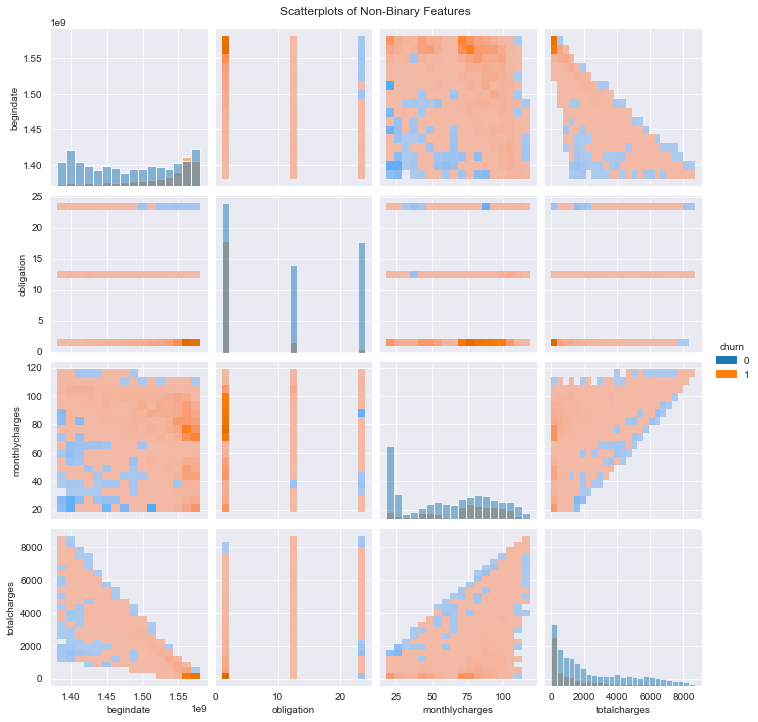

In [52]:
continuous = ['begindate', 'obligation', 'monthlycharges', 
              'totalcharges', 'churn']
g = sns.pairplot(eda[continuous], hue = 'churn', kind = 'hist')
g.figure.suptitle('Scatterplots of Non-Binary Features', y=1)
plt.show()

There is a high quantity of churned clients who's contract is monthly.

As seen in the correlation heatmap and here, many clients seem to come for a month or two, then leave, perhaps as a test trial. I would advise offering special offers and codes to new customers, and to encourage them to sign up for longer contracts.

### Data Processing


In [53]:
x = eda.drop(['churn', 'male'], axis = 1)
y = eda.churn

I dropped the target and the unnecessary column from the data.

In [54]:
x_train, x_valid, y_train, y_valid = sel.train_test_split(x, y, test_size = 0.25, random_state=3)
fitted_scaler = pro.MinMaxScaler().fit(x_train)
train_scaled = fitted_scaler.transform(x_train)
valid_scaled = fitted_scaler.transform(x_valid)

I split the data to a training set and validation set and scaled all features, fitting the scaler only on the trainig features to avoid data leakage.

In [55]:
valid_scaled[:5]

array([[0.30250648, 0.47826087, 0.        , 0.45671642, 0.40202998,
        0.        , 0.        , 0.        , 0.        , 1.        ,
        1.        , 1.        , 1.        , 0.5       , 1.        ,
        0.5       , 0.5       , 1.        , 0.        , 1.        ],
       [0.23638721, 0.47826087, 1.        , 0.71243781, 0.59019782,
        0.        , 0.        , 0.        , 1.        , 1.        ,
        1.        , 1.        , 1.        , 0.5       , 1.        ,
        0.5       , 0.5       , 0.        , 1.        , 1.        ],
       [0.65773552, 0.        , 1.        , 0.62139303, 0.25251013,
        0.        , 1.        , 0.        , 0.        , 0.        ,
        0.        , 0.5       , 0.5       , 1.        , 0.5       ,
        0.5       , 0.5       , 0.        , 1.        , 1.        ],
       [0.96024201, 0.        , 1.        , 0.55920398, 0.00857245,
        0.        , 1.        , 0.        , 1.        , 1.        ,
        0.        , 0.5       , 0.5       , 0

The scaling was successful.

### Hyperparameter Tuning


In [56]:
# preparing dictionaries for hyperparameter tuning
lingrid = dict(solver = ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'])
lgbgrid = dict(random_state = [3], 
               num_leaves= [30,35,40,45,50], 
               learning_rate=[0.005, 0.01, 0.05, 0.1], 
               n_estimators=[100,150,200,250])
forgrid = dict(random_state = [3], 
               max_leaf_nodes = [30,35,40,45,50], 
               n_estimators = [100,150,200,250], 
               min_samples_leaf = [1,3,5,7])
neigrid = dict(n_neighbors = list(range(3,30)))

params = [lingrid, lgbgrid, forgrid, neigrid]
instances = [lin.LogisticRegression(), lgb.LGBMClassifier(), 
          ens.RandomForestClassifier(), nei.KNeighborsClassifier()]
classes = ['LogisticRegression', 'LGBMClassifier', 
           'RandomForestClassifier', 'KNeighborsClassifier']

I prepared for hyperparameter tuning by creating a list of hyperparameter dictionaries, a list of instances of machine learning classes, and a list of names of classes for outputs.

In [57]:
mean_scores = []
for i in tqdm(range(len(instances))):
    temp = sel.GridSearchCV(instances[i], 
                            params[i], 
                            scoring = 'roc_auc')
    temp.fit(train_scaled, y_train)
    mean_scores.append(temp.cv_results_['mean_test_score'])
    print('The best parameters for the',classes[i],'model for this data are:',temp.best_params_)

  0%|          | 0/4 [00:00<?, ?it/s]

The best parameters for the LogisticRegression model for this data are: {'solver': 'liblinear'}
The best parameters for the LGBMClassifier model for this data are: {'learning_rate': 0.1, 'n_estimators': 250, 'num_leaves': 30, 'random_state': 3}
The best parameters for the RandomForestClassifier model for this data are: {'max_leaf_nodes': 50, 'min_samples_leaf': 1, 'n_estimators': 250, 'random_state': 3}
The best parameters for the KNeighborsClassifier model for this data are: {'n_neighbors': 28}


I've found the best hyperparameters for each model, but I'd like to compare their overall performance when cross-validated on this data.

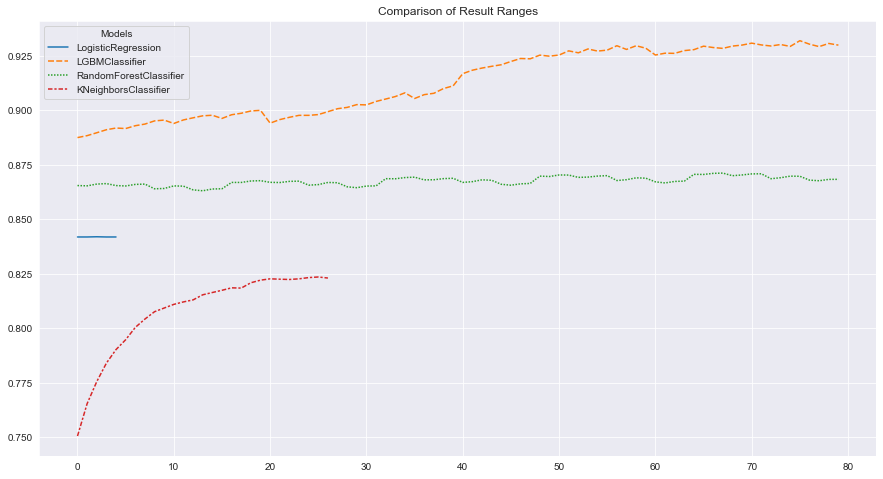

In [58]:
fig = plt.figure(figsize = (15,8))
sns.lineplot(data = mean_scores, legend = False).set(title = 'Comparison of Result Ranges')
plt.legend(title='Models', loc='upper left', labels=classes)
plt.show()

##### Model Selection
The light gradient boosting model performed better than the rest with every set of hyperparameters.

##### Feature Importances
Trying to check whether any columns are leaking the target.

The nearest neighbors classifier doesn't have such an attribute, so I will skip it. Technically, neither does the linear classifier, but <a href = 'https://machinelearningmastery.com/calculate-feature-importance-with-python/#:~:text=Linear%20Regression%20Feature%20Importance,-We%20can%20fit&text=These%20coefficients%20can%20provide%20the,prior%20to%20fitting%20a%20model.'>since all of the data is scaled</a>, more important features will have coefficients that are further from zero compared to less important features.

In [59]:
# fitting instances with tuned params
linear = lin.LogisticRegression(solver = 'saga').fit(train_scaled, y_train)
fores = ens.RandomForestClassifier(random_state = 3,
                                  max_leaf_nodes=50, min_samples_leaf=1,
                                  n_estimators = 200).fit(train_scaled, y_train)
lgbc = lgb.LGBMClassifier(learning_rate=0.1, random_state=3,
                         n_estimators=250, num_leaves=40).fit(train_scaled, y_train)

Now that I have three models trained on this data, I can view feature importances and coefficients through their attributes.

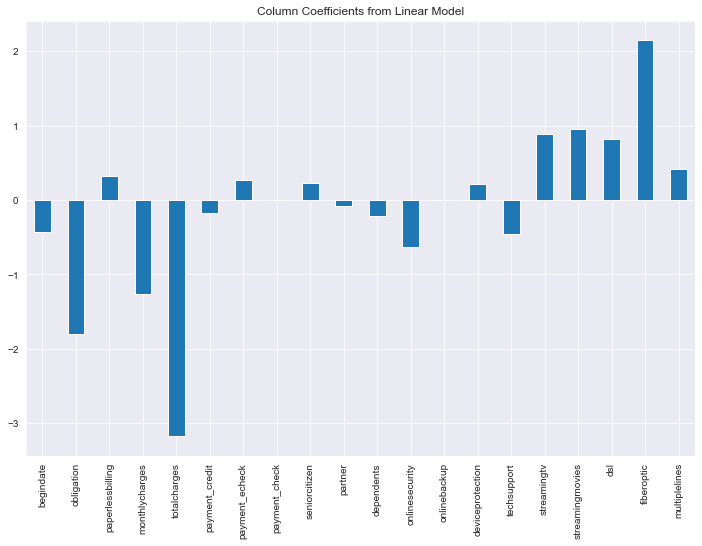

In [60]:
fig = pd.Series(linear.coef_.flatten()).plot(kind = 'bar', figsize = (12,8))
fig.set_title('Column Coefficients from Linear Model')
fig.set_xticklabels(x.columns)
plt.show()

The totalcharges column stands out with the largest absolute coefficient, followed by fiberoptic.

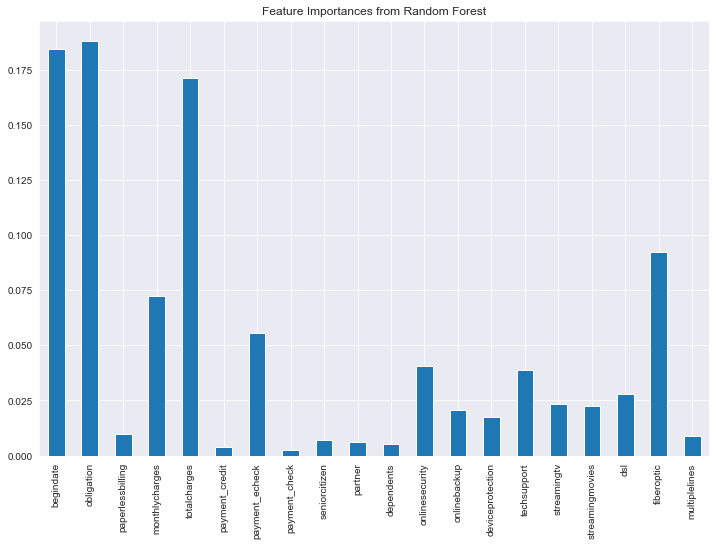

In [61]:
fig = pd.Series(fores.feature_importances_).plot(kind = 'bar', figsize = (12,8))
fig.set_title('Feature Importances from Random Forest')
fig.set_xticklabels(x.columns)
plt.show()


The columns begindate, obligation, and totalcharges have the highest importances according to the random forest classifier.

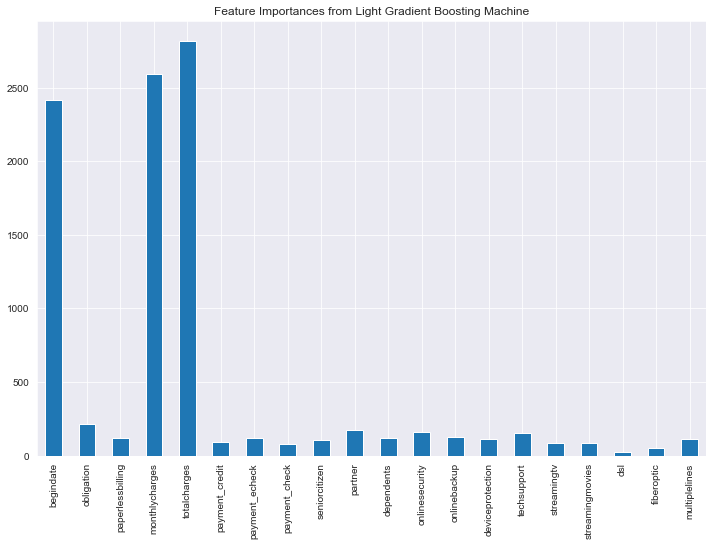

In [62]:
fig = pd.Series(lgbc.feature_importances_).plot(kind = 'bar', figsize = (12,8))
fig.set_title('Feature Importances from Light Gradient Boosting Machine')
fig.set_xticklabels(x.columns)
plt.show()



The columns deemed most important by the LightGBM classifier are begindate, monthly charges and total charges.

The amount of money a client has paid the company so far, the totalcharges column, is very influential in determining churn. Since that is information the model will have when predicting for Interconnect, I don't think that's target leakage.

### Model Evaluation
I will define a function which calculates and graphs model scores. I will also do a sanity check to set a baseline for the model's results.

In [63]:
def evaluate_model(model, train_features, train_target, test_features, test_target, title):
    #function recieves all data and the model
    eval_stats = {}
    
    fig, axs = plt.subplots(1, 3, figsize=(20, 6)) #preparing for multiple subplots
    
    for type, features, target in (('train', train_features, train_target), #runs once for each dataset
                                   ('test', test_features, test_target)):
        
        eval_stats[type] = {} #"type" here isn't a keyword but a string variable
        #eval_stats will be, in total, a dictionary containing two dictionaries as values
    
        pred_target = model.predict(features)
        pred_proba = model.predict_proba(features)[:, 1]
        #predictions for evaluation
        # F1
        f1_thresholds = np.arange(0, 1.01, 0.05)
        f1_scores = [met.f1_score(target, pred_proba>=threshold) for threshold in f1_thresholds]
        
        # ROC (auc: area under curve, roc: reciever operating characteristic)
        fpr, tpr, roc_thresholds = met.roc_curve(target, pred_proba)
        roc_auc = met.roc_auc_score(target, pred_proba)  
        eval_stats[type]['ROC AUC'] = roc_auc #declaring key and value in dictionary inside dictionary

        # PRC: precision recall curve
        precision, recall, pr_thresholds = met.precision_recall_curve(target, pred_proba)
        aps = met.average_precision_score(target, pred_proba)
        eval_stats[type]['APS'] = aps #declaring key and value in dictionary inside dictionary

        #different colored graphs for each dataset
        if type == 'train':
            color = 'blue'
        else:
            color = 'green'

        # F1 Score
        ax = axs[0]
        max_f1_score_idx = np.argmax(f1_scores)
        ax.plot(f1_thresholds, f1_scores, color=color, 
                label=
                f'{type}, max={f1_scores[max_f1_score_idx]:.2f} @ {f1_thresholds[max_f1_score_idx]:.2f}')
        # setting crosses for some thresholds
        for threshold in (0.2, 0.4, 0.5, 0.6, 0.8):
            closest_value_idx = np.argmin(np.abs(f1_thresholds-threshold))
            marker_color = 'red' if threshold == 0.5 else 'orange'
            ax.plot(f1_thresholds[closest_value_idx], f1_scores[closest_value_idx], 
                    color=marker_color, marker='X', markersize=7)
        ax.set_xlim([-0.02, 1.02])    
        ax.set_ylim([-0.02, 1.02])
        ax.set_xlabel('threshold')
        ax.set_ylabel('F1')
        ax.legend(loc='lower center')
        ax.set_title(f'F1 Score') 

        # ROC
        ax = axs[1]    
        ax.plot(fpr, tpr, color=color, label=f'{type}, ROC AUC={roc_auc:.2f}')
        # setting crosses for some thresholds
        for threshold in (0.2, 0.4, 0.5, 0.6, 0.8):
            closest_value_idx = np.argmin(np.abs(roc_thresholds-threshold))
            marker_color = 'red' if threshold == 0.5 else 'orange'            
            ax.plot(fpr[closest_value_idx], tpr[closest_value_idx], color=marker_color, marker='X', markersize=7)
        ax.plot([0, 1], [0, 1], color='grey', linestyle='--')
        ax.set_xlim([-0.02, 1.02])    
        ax.set_ylim([-0.02, 1.02])
        ax.set_xlabel('FPR')
        ax.set_ylabel('TPR')
        ax.legend(loc='lower center')        
        ax.set_title(f'ROC Curve')
        
        # PRC
        ax = axs[2]
        ax.plot(recall, precision, color=color, label=f'{type}, AP={aps:.2f}')
        # setting crosses for some thresholds
        for threshold in (0.2, 0.4, 0.5, 0.6, 0.8):
            closest_value_idx = np.argmin(np.abs(pr_thresholds-threshold))
            marker_color = 'red' if threshold == 0.5 else 'orange'
            ax.plot(recall[closest_value_idx], precision[closest_value_idx], color=marker_color, marker='X', markersize=7)
        ax.set_xlim([-0.02, 1.02])    
        ax.set_ylim([-0.02, 1.02])
        ax.set_xlabel('recall')
        ax.set_ylabel('precision')
        ax.legend(loc='lower center')
        ax.set_title(f'PRC')        

        eval_stats[type]['Accuracy'] = met.accuracy_score(target, pred_target)
        eval_stats[type]['F1'] = met.f1_score(target, pred_target)
    
    df_eval_stats = pd.DataFrame(eval_stats)
    df_eval_stats = df_eval_stats.round(2)
    df_eval_stats = df_eval_stats.reindex(index=('Accuracy', 'F1', 'APS', 'ROC AUC'))
    fig.suptitle(title)
    plt.show()
    print(df_eval_stats)
    
    return #a void function

##### Sanity Check
I will be using a dummy classifier to predict a constant.

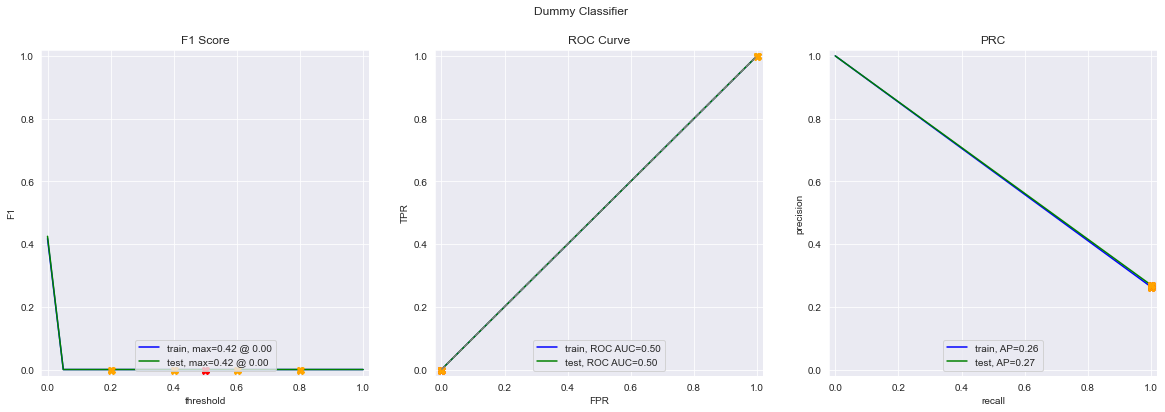

          train  test
Accuracy   0.74  0.73
F1         0.00  0.00
APS        0.26  0.27
ROC AUC    0.50  0.50


In [64]:
dummy = dum.DummyClassifier(strategy = 'most_frequent')
dummy.fit(x_valid, y_valid) #will predict 1 for every observation
evaluate_model(dummy, x_train, y_train, x_valid, y_valid, 'Dummy Classifier')

##### Testing the Model on the Validation Data


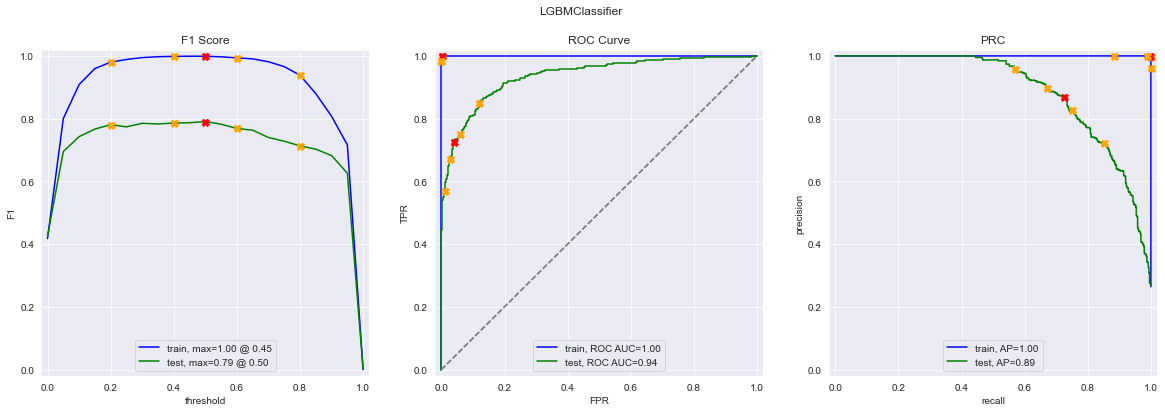

          train  test
Accuracy    1.0  0.90
F1          1.0  0.79
APS         1.0  0.89
ROC AUC     1.0  0.94


In [65]:

evaluate_model(lgbc, train_scaled, y_train, valid_scaled, y_valid, classes[1])

### Model Selection
The recommended model is a LGBMClassifier class with a learning rate of 0.1, 250 estimators, and a maximum of 40 leaves for each learner, trained on scaled data.

# Conclusion
In this project I have:
- Performed data preprocessing:
    - Removed values filling in for null.
    - Changed data types to correct types.
    - Converted object types to numeric values while preserving their meaning as much as possible.
    - Joining the tables into a combined dataset.
- Explored and Analysed the data.
- Performed data processing:
    - Dropped columns which did not seem to contribute.
    - Encoded features using label encoding and One Hot Encoding.
    - Split the data into training and validation datasets.
    - Scaled the features.
- Used cross validation:
    - To tune hyperparameters.
    - To select the model that works the best for this data.
- Checked for target leakage.
- Used a dummy model for a sanity check.
- Evaluated the selected model.
### Recommendations 
- To convert the data to numeric features, scale them, and predict churn using a LightGBM classifier with a learning rate of 0.1, 250 estimators, and a maximum of 40 leaves for each learner.
- To offer promotional codes and special plan options to new clients to encourage them to stay.
